<a href="https://colab.research.google.com/github/agustinparada/Fisica_Computacional_I/blob/master/Evaluacion1/Evaluacion1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Evaluación 1***

José Agustín Parada Peralta.

Departamento de Física.

Universidad de Sonora.

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as pdut

# ***PARTE 1***
En la siguiente sección, importamos los datos del observatorio Tutuila, Samoa Americana.

In [133]:
# Definimos la URL del archivo con los datos desde la página web indicada de los datos de CO2 en Samoa Americana, al igual que le asignamos los parámetros necesarios para su correcta lectura.
# También definimos el nombre de las columnas del dataframe.
url='https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_smo_DailyData.txt'

columnas=['site_code', 'year', 'month', 'day', 'hour', 'minute', 'second', 'time_decimal', 'value', 'texto', 'nvalue', 'latitude', 'longitude', 'altitude', 'elevation', 'intake_height', 'qcflag']
col_drop=['site_code','hour', 'minute', 'second', 'time_decimal', 'texto', 'nvalue', 'latitude', 'longitude', 'altitude', 'elevation', 'intake_height', 'qcflag']

# Leemos los datos en un Dataframe
df=pd.read_csv(url, names=columnas, skiprows=151, header=None, sep='\s+', encoding='cp1251', engine='python')

# Borramos los datos no requeridos
df1=df.drop(columns=col_drop)

# Nos deshacemos de los valores nulos
valor=-999.99
df1=df1.replace(to_replace=valor, value=np.nan, regex=True)

df2=df1.copy()

# Combinamos las columnas de año, mes y día en una sola con datos de tipo object para su posterior conversión a datos datetime
fecha=['day','month','year']
df2['Fecha']=''
for a in fecha:
  df2['Fecha']=df2['Fecha']+df2[a].map(str)
  if a!='year':
    df2['Fecha']=df2['Fecha']+'/'

# Conversión de datos a 'datetime'
df2['Fecha']=pd.to_datetime(df2['Fecha'], dayfirst=True)
df2=df2.set_index('Fecha')

# Seleccionamos los datos a partir de 1980
cols_drop=['year','month','day']
df3=df2[(df2['year']>=1980)]
df3=df3.drop(columns=cols_drop)
ts_test=df3.copy()

# Rellenamos los valores nulos
ts_test.ffill(axis=0, inplace=True)
ts_test=ts_test['value'].copy()
ts_test


Fecha
1980-01-01    337.25
1980-01-02    337.25
1980-01-03    337.56
1980-01-04    337.69
1980-01-05    337.83
               ...  
2019-12-27    410.89
2019-12-28    410.89
2019-12-29    410.89
2019-12-30    410.89
2019-12-31    410.89
Name: value, Length: 14610, dtype: float64

# ***PARTE 2***
En esta sección, nos dedicamos a la obtención de un modelo de predicción.
Se utilizan pruebas de estacionaridad, métodos para hacer estacionarias a las series de tiempo, y se utiliza el modelo ARIMA para llevar a cabo la predicción.

In [134]:
#Definimos la fucnión de prueba de Dickey-Fuller para hacer el proceso de prueba de estacionaridad más práctico
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles anuales
    rolmean = df_ts.rolling(window=365, center=True, min_periods=1).mean()
    rolstd = df_ts.rolling(window=365, center=True, min_periods=1).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Media móvil anual')
    plt.plot(rolstd, color='black', label = 'Desviación estándar móvil')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','valor de p','#Lags Usados','Número de observaciones usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valor Crítico (%s)'%key] = value
    print(dfoutput)

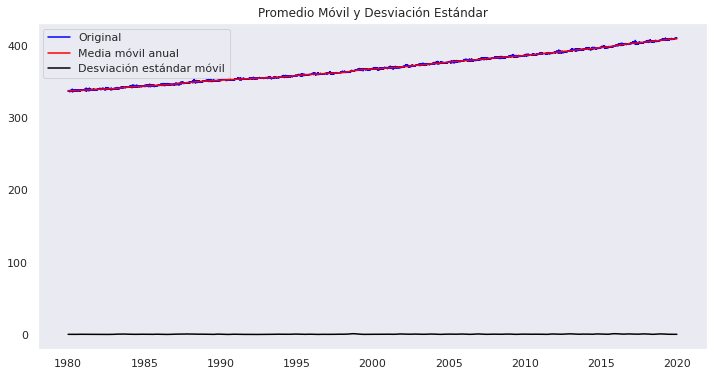

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                        1.351348
valor de p                            0.996882
#Lags Usados                         39.000000
Número de observaciones usadas    14570.000000
Valor Crítico (1%)                   -3.430799
Valor Crítico (5%)                   -2.861738
Valor Crítico (10%)                  -2.566876
dtype: float64


In [135]:
# Aplicamos la prueba de estacionaridad a ts_test
test_stationarity(ts_test)

Observamos que la serie de tiempo del CO2 no es estacionaria (p>0.05), por lo que procedemos a aplicar métodos para hacerla estacionaria. Comenzamos aplicando la escala logarítmica para después aplicar distntos métodos para hacer estacionaria a la serie de tiempo.

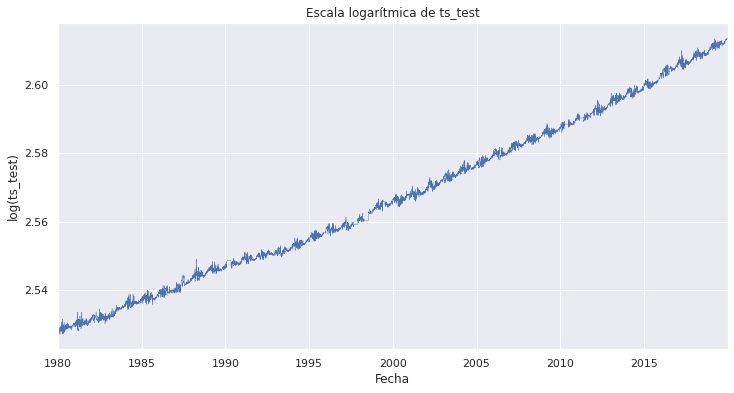

In [136]:
# Aplicamos el logaritmo base 10 a los datos, y graficamos
ts_test_log=np.log10(ts_test)
ts_test_log.plot(linewidth=0.4,ylabel='log(ts_test)', title='Escala logarítmica de ts_test')

# Obtenemos la media móvil de los datos en escala logarítmica
ts_test_log_M365=ts_test_log.rolling(365, center=True, min_periods=1).mean()


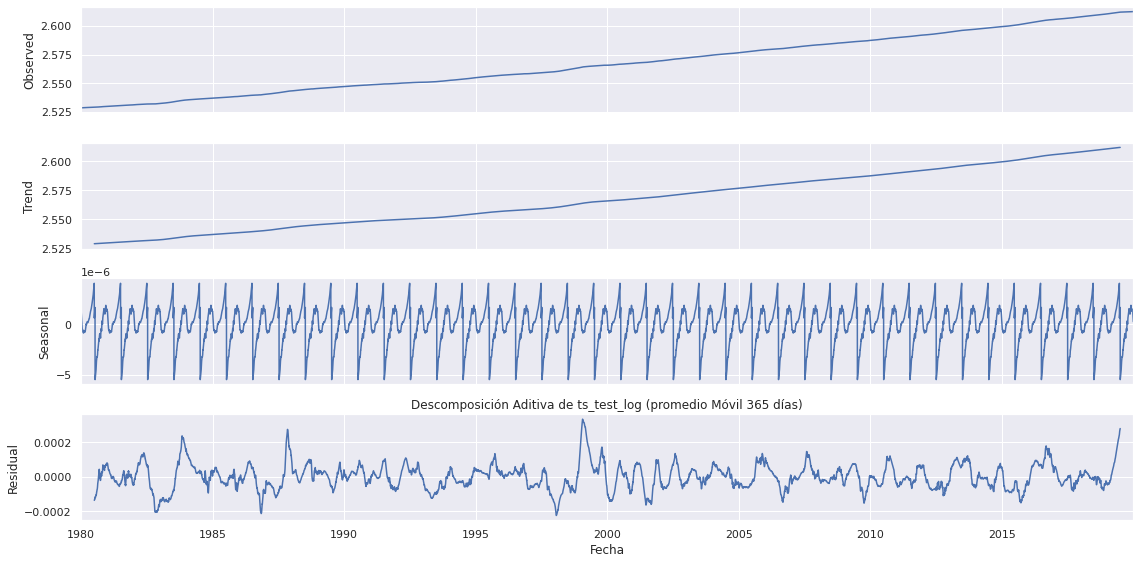

In [137]:
# Realizamos la descomposición estacional con promedio anual
# Definimos el tamaño de la figura
sb.set(rc={'figure.figsize':(16,8)})

decomp=365

# Descomponemos la serie de tiempo en observado, tendencia, estacional y residuo
decCO2=sm.tsa.seasonal_decompose(ts_test_log_M365.interpolate(), freq=decomp, model='additive')

# Graficamos las partes descompuestas por separado
decCO2.plot()

plt.title('Descomposición Aditiva de ts_test_log (promedio Móvil 365 días)')
plt.xlabel('Fecha')

ts_test_log_decomp=decCO2.resid
ts_test_log_decomp.dropna(inplace=True)

***Comentarios acerca de los componentes de la descomposición***



*Tendencia*: Es se ve una tendencia no muy notoria, una tendencia mínima de aumento.

*Estacional*: Se pueden observar ciclos a lo largo de los años. La estacionalidad es muy pequeña, prácticamente nula.

*Residuo*: Este es caótico, posiblemente las variaciones de log(CO2) dadas situaciones puntuales.

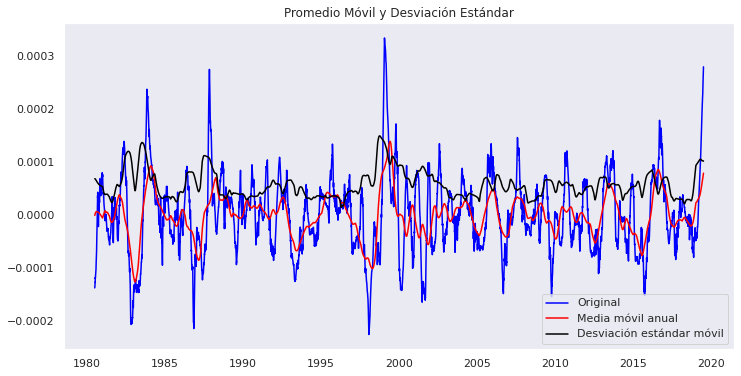

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -8.933504e+00
valor de p                        9.672181e-15
#Lags Usados                      3.800000e+01
Número de observaciones usadas    1.420700e+04
Valor Crítico (1%)               -3.430810e+00
Valor Crítico (5%)               -2.861743e+00
Valor Crítico (10%)              -2.566878e+00
dtype: float64


In [138]:
# Aplicamos la prueba de estacionaridad a la serie de tiempo residuo, producto de la descomposición estacional
test_stationarity(ts_test_log_decomp)

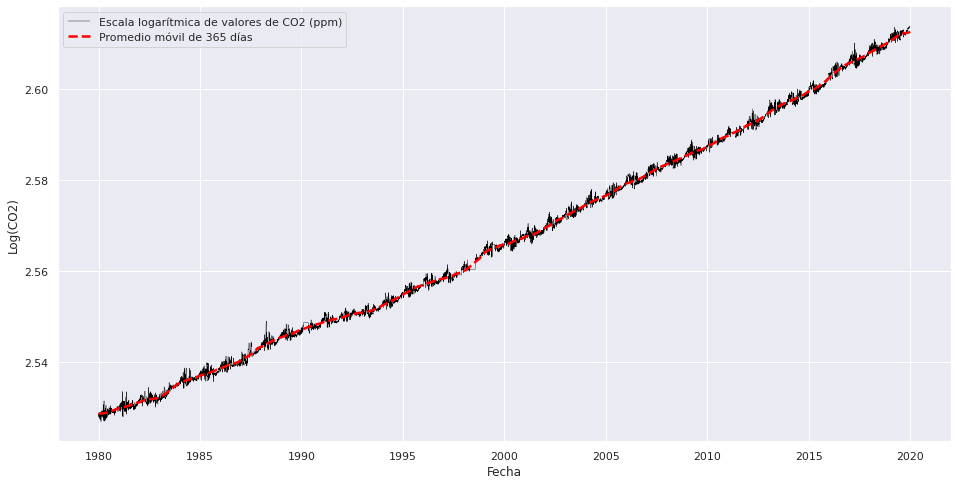

In [139]:
# Obtenemos el periodo a 365 días
ts_test_log_P365=ts_test_log.rolling(365, center=True, min_periods=1).mean()

#Graficamos la escala logarítmica contra su promedio móvil
sb.set(rc={'figure.figsize':(16,8)})
fig, ax=plt.subplots()

ax.plot(ts_test_log, linewidth=0.4, color='black', label='Escala logarítmica de valores de CO2 (ppm)')
ax.plot(ts_test_log_P365, linestyle='--', linewidth=2.5, color='red', label='Promedio móvil de 365 días')
ax.set_ylabel('Log(CO2)')
ax.set_xlabel('Fecha')
ax.legend()

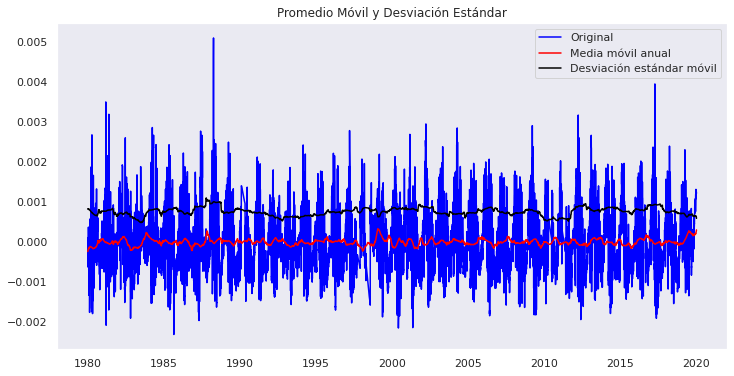

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -1.292781e+01
valor de p                        3.755416e-24
#Lags Usados                      2.800000e+01
Número de observaciones usadas    1.458100e+04
Valor Crítico (1%)               -3.430799e+00
Valor Crítico (5%)               -2.861738e+00
Valor Crítico (10%)              -2.566876e+00
dtype: float64


In [140]:
# Obtenemos la diferencia entre La escala logarítmica y su promedio móvil de 365 días
ts_test_log_dif=ts_test_log-ts_test_log_P365

#Aplicamos la prueba de estacionaridad de Dickey - FUller
test_stationarity(ts_test_log_dif)

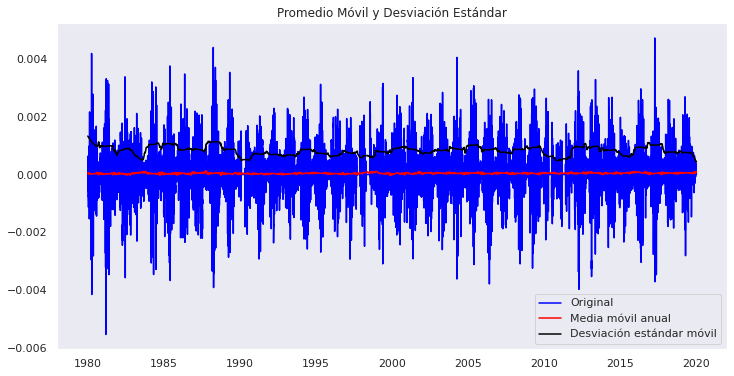

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                      -22.689055
valor de p                            0.000000
#Lags Usados                         42.000000
Número de observaciones usadas    14560.000000
Valor Crítico (1%)                   -3.430799
Valor Crítico (5%)                   -2.861739
Valor Crítico (10%)                  -2.566876
dtype: float64


In [141]:
# Diferenciamos la escala logarítmica con su aplicación de la función shift() con periodo de 7 días
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)

# Nos deshacemos de los datos nulos
ts_test_log_diff.dropna(inplace=True)

# Aplicamos prueba de estacionaridad
test_stationarity(ts_test_log_diff)

Notemos que con los métodos previamente utilizados, las series de tiempo son estacionarias, pues tienen un valor de p mucho menor que 0.05.

# ***Método ARIMA***
Utilizaremos el modelo ARIMA para obtener un modelo de los datos.
Contrastaremos entre los modelos:

*AR*: Auto - Regresivo

*MA*: Media Móvil

*ARIMA*: AR + MA Integrados

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


De aquí, tenemos que p=2; q=4


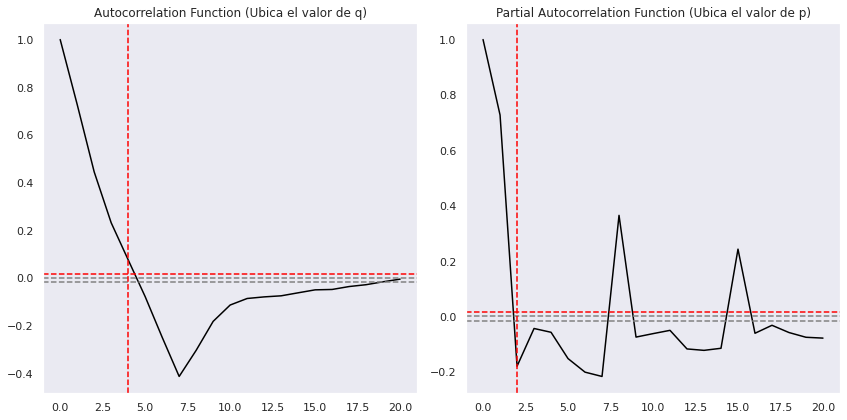

In [142]:
lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf,color='black')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='red')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='red')
plt.axvline(x=4, linestyle='--', color='red')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf,color='black')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='red')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='red')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()
print('De aquí, tenemos que p=2; q=4')

In [143]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14609
Model:                 ARIMA(2, 1, 0)   Log Likelihood               92545.287
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -185082.574
Time:                        02:02:24   BIC                        -185052.217
Sample:                    01-02-1980   HQIC                       -185072.489
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.867e-06   3.09e-06      1.897      0.058   -1.94e-07    1.19e-05
ar.L1.D.value    -0.0003      0.008     -0.033      0.974      -0.016       0.016
ar.L2.D.value    -0.1478      0.008    -

In [144]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14609
Model:                 ARIMA(0, 1, 4)   Log Likelihood               93057.421
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -186102.843
Time:                        02:02:29   BIC                        -186057.306
Sample:                    01-02-1980   HQIC                       -186087.715
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.848e-06   1.02e-06      5.721      0.000    3.84e-06    7.85e-06
ma.L1.D.value    -0.0998      0.008    -12.144      0.000      -0.116      -0.084
ma.L2.D.value    -0.2501      0.008    -

In [145]:
 #Aplicamos el modelo ARIMA(p,d,q)=(2,1,4)
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
print(results_ARIMA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14609
Model:                 ARIMA(2, 1, 4)   Log Likelihood               93159.163
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -186302.326
Time:                        02:02:47   BIC                        -186241.611
Sample:                    01-02-1980   HQIC                       -186282.156
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.845e-06   7.53e-07      7.757      0.000    4.37e-06    7.32e-06
ar.L1.D.value     0.2368        nan        nan        nan         nan         nan
ar.L2.D.value     0.2229        nan     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


***Selección del mejor modelo***

Modelo AR (p,d,q)=(2,1,0) -> AIC=-185082.574

Modelo MA (p,d,q)=(0,1,4) -> AIC=-186102.843

Modelo ARIMA (p,d,q)=(2,1,4) -> AIC=-186302.326

***Por lo tanto, el modelo ARIMA(2,1,4) es el mejor***

***Predicción del modelo***

Se contrasta el modelo con los datos originales de CO2 en ppm.


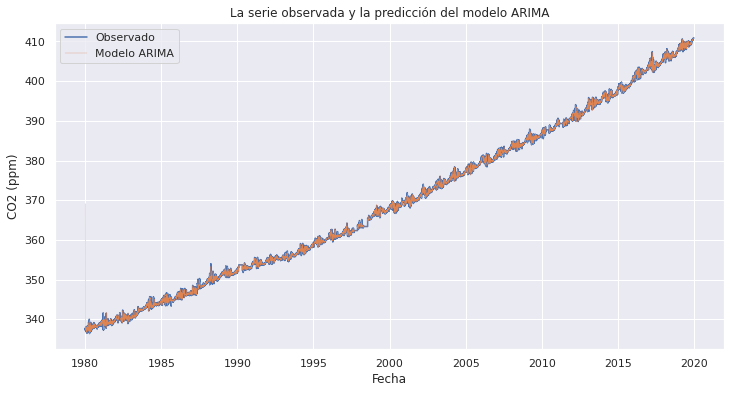

In [146]:
# Creamos un dataframe para almacenar las predicciones de ARIMA(2,1,4) (el último aplicado). TEMP. MÁXIMAS
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

# Añadimos las predicciones ARIMA a la serie observada
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
predictions_ARIMA_log.fillna(predictions_ARIMA_log.mean(),inplace=True)

# Regresamos a los datos originales rivirtiendo la escala logarítmica.
predictions_ARIMA = 10**(predictions_ARIMA_log)

# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

#Graficamos
plt.plot(ts_test, label='Observado')
plt.plot(predictions_ARIMA, linewidth=0.3, label='Modelo ARIMA')
plt.xlabel('Fecha')
plt.ylabel('CO2 (ppm)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best')


In [147]:
# Obtenemos el error de la predicción
RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 0.2888331571004193


***Observamos con detalle la predicción de los últimos 5 años respecto de sus correspondientes datos originales***

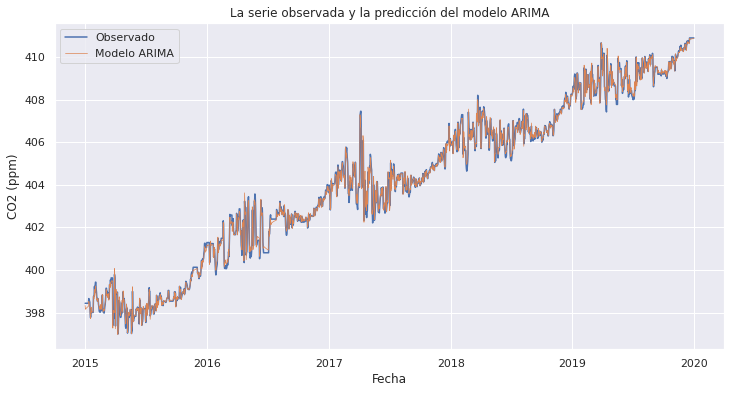

In [148]:
# Delimitamos a las series de tiempo a los últimos 5 años (2015-2020)
ts_test_5=ts_test.loc['2015-01-01':'2019-12-31']
predictions_ARIMA_5=predictions_ARIMA.loc['2015-01-01':'2019-12-31']

# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Graficamos
plt.plot(ts_test_5, label='Observado')
plt.plot(predictions_ARIMA_5, linewidth=0.7, label='Modelo ARIMA')
plt.xlabel('Fecha')
plt.ylabel('CO2 (ppm)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best')